In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, ConvLSTM2D, Conv2D, MaxPooling3D, GRU, LSTM, MaxPooling3D,\
                                    GlobalAveragePooling2D,Conv3D, Flatten, Dropout, TimeDistributed,\
                                    Lambda, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import squeeze
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [41]:
count_cadrs = 28
x_size = 144
y_size = 144
count_classes = 23
n_ports = 3
n_videos = 4

In [45]:
data_frame = pd.DataFrame(columns=['video', 'class_name'])
index = 0
url = '/home/jupyter/datasphere/project/D/Stavropol/Videos'
list_names = os.listdir(url)

for name in list_names:
    print('------->',name, '<-------')
    new_url_1 = url+f'/{name}'
    list_videos_name = os.listdir(new_url_1)
    
    for video in list_videos_name[:40]:
        new_url_2 = new_url_1 + f'/{video}'
        cap = cv2.VideoCapture(new_url_2)
        num = -1
        frames = []
        
        while(cap.isOpened()):
            num += 1
            if num in [2, 4]:
                continue
            ret, frame = cap.read()
            if (ret == True):
                if num % 2 == 0:
                    # Преобразование кадра в тензор
                    frame = cv2.resize(frame, (x_size, y_size)) # Изменение размера кадра
                    frame = frame / 255.0 # Нормализация пикселей
                    frame = np.expand_dims(frame, axis=[0]) # Добавление измерения для тензора
                    frames.append(frame)
            else:
                break
            if len(frames) == count_cadrs:
                #print('Попалось видео с недостатком кадров')
                break
        
        # Преобразование списка тензоров в тензор
        try:
            frames = np.concatenate(frames, axis=0)
        except ValueError:
            pass
        if frames.shape[0] < count_cadrs:
            continue    
        #print(frames.shape)
        data_frame.loc[index, 'video'] = frames
        data_frame.loc[index, 'class_name'] = name
        index += 1
        cap.release()
        cv2.destroyAllWindows()
    #print('--------------------------------------------------------------------------------------------------')
#print(data_frame['video'].shape)

-------> cartwheel <-------
-------> catch <-------
-------> clap <-------
-------> climb <-------
-------> dive <-------
-------> draw_sword <-------
-------> dribble <-------
-------> fencing <-------
-------> flic_flac <-------
-------> golf <-------
-------> handstand <-------
-------> hit <-------
-------> jump <-------
-------> pick <-------
-------> pour <-------
-------> pullup <-------
-------> push <-------
-------> pushup <-------
-------> shoot_ball <-------
-------> sit <-------
-------> situp <-------
-------> swing_baseball <-------
-------> sword_exercise <-------
-------> throw <-------
-------> assets <-------
-------> .ipynb_checkpoints <-------


In [46]:
encoder = LabelEncoder()
d_ = encoder.fit_transform(data_frame['class_name'])
d_
data_frame['class_name'] = d_
data_frame['class_name'].max()

22

In [47]:
X = np.array(data_frame['video'].tolist())
y = to_categorical(data_frame['class_name'], num_classes=count_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [54]:
model = Sequential([
    ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
               recurrent_dropout=0.2, return_sequences=True, 
               input_shape = (count_cadrs, x_size, y_size, n_ports)),
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    #TimeDistributed(Dropout(0.2)),
    
    ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
               recurrent_dropout=0.2, return_sequences=True),
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    #TimeDistributed(Dropout(0.2)),
    
    ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
               recurrent_dropout=0.2, return_sequences=True),
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    TimeDistributed(Dropout(0.2)),
    
    ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
               recurrent_dropout=0.2, return_sequences=True),
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    TimeDistributed(Dropout(0.2)),
    
    Flatten(),
    Dense(16, activation='linear'),
    Dense(32, activation='linear'),
    Dense(count_classes, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_16 (ConvLSTM2D)  (None, 28, 142, 142, 8)  3200      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 28, 71, 71, 8)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_17 (ConvLSTM2D)  (None, 28, 69, 69, 4)    1744      
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 28, 35, 35, 4)    0         
 g3D)                                                            
                                                                 
 conv_lstm2d_18 (ConvLSTM2D)  (None, 28, 33, 33, 8)    3488      
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 28, 17, 17, 8)   

In [55]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', 
                                        restore_best_weights = True)

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
train_history = model.fit(X_train, y_train,
                          epochs=10,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stopping_callback])

Epoch 1/10


2023-11-12 02:51:42.311754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/conv_lstm2d_16/while/body/_1/sequential_4/conv_lstm2d_16/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 35s 1s/step - loss: 3.1132 - accuracy: 0.0465 - val_loss: 3.0317 - val_accuracy: 0.0588
Epoch 2/10
15/15 [==============================] - 16s 1s/step - loss: 3.0196 - accuracy: 0.1057 - val_loss: 2.8584 - val_accuracy: 0.1765
Epoch 3/10
15/15 [==============================] - 16s 1s/step - loss: 2.7289 - accuracy: 0.2178 - val_loss: 2.5745 - val_accuracy: 0.2521
Epoch 4/10
15/15 [==============================] - 16s 1s/step - loss: 2.3325 - accuracy: 0.3362 - val_loss: 2.3611 - val_accuracy: 0.3361
Epoch 5/10
15/15 [==============================] - 16s 1s/step - loss: 1.8925 - accuracy: 0.4672 - val_loss: 2.2959 - val_accuracy: 0.3445
Epoch 6/10
15/15 [==============================] - 16s 1s/step - loss: 1.4964 - accuracy: 0.5603 - val_loss: 2.2766 - val_accuracy: 0.3782
Epoch 7/10
15/15 [==============================] - 16s 1s/step - loss: 1.1945 - accuracy: 0.6596 - val_loss: 2.0537 - val_accuracy: 0.4874
Epoch 8/10
15/15 [=============

In [61]:
test_history = model.evaluate(X_test, y_test)
test_history

5/5 [==============================] - 1s 208ms/step - loss: 3.4363 - accuracy: 0.4027


[3.436281681060791, 0.4026845693588257]

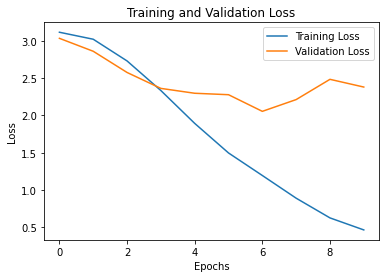

In [79]:
# Plotting Training and Validation Loss
plt.figure()
plt.plot(train_history.history['loss'], label='Training Loss')
plt.plot(train_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

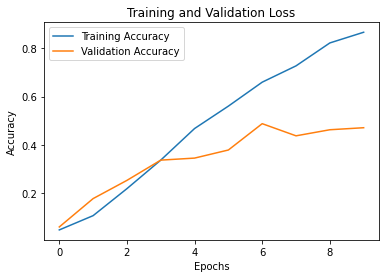

In [95]:
# Plotting Training and Validation Loss
plt.figure()
plt.plot(train_history.history['accuracy'], label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.save(f'/home/jupyter/datasphere/project/Models/NN_acc_38')

In [ ]:

def getFrames(video_path):
    cap = cv2.VideoCapture(video_path)
    num = -1
    frames = []

    while(cap.isOpened()):
        num += 1
        if num in [2, 4]:
            continue
        ret, frame = cap.read()
        if (ret == True):
            if num % 2 == 0:
                # Преобразование кадра в тензор
                frame = cv2.resize(frame, (x_size, y_size)) # Изменение размера кадра
                frame = frame / 255.0 # Нормализация пикселей
                frame = np.expand_dims(frame, axis=[0]) # Добавление измерения для тензора
                frames.append(frame)
        else:
            break
        if len(frames) == count_cadrs:
            #print('Попалось видео с недостатком кадров')
            break

    # Преобразование списка тензоров в тензор
    try:
        frames = np.concatenate(frames, axis=0)
    except ValueError:
        pass  
    return frames.reshape((1, 28, 144,144,3))


np.argmaxmodel.predict(getFrames("/home/jupyter/datasphere/project/D/Stavropol/D/videos_little/draw_sword/Eishin_Ryu_Iaido_-_Toho_Forms_draw_sword_f_cm_np1_le_med_1.avi"))